# Dataset Preview

## Notebook Configuration 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from storesales.constants import EXTERNAL_DATA_PATH, SUBMISSIONS_PATH
from storesales.explore.utils import (
    compute_weekly_corr,
    plot_corr_per_store,
    get_holidays_on_sales_fig,
)

# External Data Exploration

Data Source: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

## Table of Contents

1. **[train.csv](#traincsv)**
   - [Train Summary](#train-summary)
   - [Train Info](#train-info)
   - [Exploring Data](#exploring-data)
     - [Date Gaps](#date-gaps)
     - [Sales Distribution](#sales-distribution)
     - [Store vs Family Sales](#store-vs-family-sales)
     - [Family Sales vs Store](#family-sales-vs-store)
     - [Family Sales Correlation](#family-sales-correlation)

2. **[test.csv](#testcsv)** 
   - [Summary](#summary)
   - [Dataset Info](#dataset-info)  
  
3. **[holidays_events.csv](#holidays_eventscsv)** 
   - [Summary](#summary-1)
   - [Dataset Info](#dataset-info-1)
   - [Exploring Holidays](#exploring-holidays)
     - [Holidays in Train Period](#holidays-in-train-period)
     - [Holidays in Test Period](#holidays-in-test-period)

4. **[oil.csv](#oilcsv)** 
   - [Summary](#summary-2)
   - [Oil Info](#oil-info)
   - [Exploring Oil Data](#exploring-oil-data)
     - [Test Period](#test-period)
     - [Date Gaps](#date-gaps-1)
     - [Plotting Oil Prices Over Time](#plotting-oil-prices-over-time)
     - [Oil Correlation with Sales](#oil-correlation-with-sales) 
       - [Global Correlation](#global-correlation)
       - [Per Store Correlation](#per-store-correlation)
       - [Per Week Correlation](#per-week-correlation)
       - [Weekly Mean abs Correlation](#weekly-mean-abs-correlation)

5. **[stores.csv](#storescsv)**  
   - [Summary](#summary-3)
   - [Stores Info](#stores-info)
   - [Exploring Stores Data](#exploring-stores-data)
     - [Sales by Store Type](#sales-by-store-type)
     - [Family Sales by Store Type](#family-sales-by-store-type)
       - [Normalized by Row](#normalized-by-row)
       - [Normalized by Column](#normalized-by-column)
     - [Sales to Day of Week](#sales-to-day-of-week)
       - [Normalized by Row](#normalized-by-row-1)
       - [Normalized by Column](#normalized-by-column-1)

6. **[transactions.csv](#transactionscsv)** 
   - [Summary](#summary-4)
   - [Transactions Info](#transactions-info)
   - [Exploring Transactions Data](#exploring-transactions-data)
     - [Date Gaps](#date-gaps-2)
     - [Transactions Over Time for All Stores](#transactions-over-time-for-all-stores)
     - [Store Transactions Correlation with Sales](#store-transactions-correlation-with-sales)
       - [Global Correlation](#global-correlation-1)
       - [Per Store Correlation](#per-store-correlation-1)
       - [Local Correlation](#local-correlation)

7. **[sample_submission.csv](#sample_submissioncsv)** 
   - [mean sales per store](#mean-sales-per-store)

In [3]:
train_path = os.path.join(EXTERNAL_DATA_PATH, "train.csv")
test_path = os.path.join(EXTERNAL_DATA_PATH, "test.csv")
holidays_events_path = os.path.join(EXTERNAL_DATA_PATH, "holidays_events.csv")
oil_path = os.path.join(EXTERNAL_DATA_PATH, "oil.csv")
stores_path = os.path.join(EXTERNAL_DATA_PATH, "stores.csv")
transactions_path = os.path.join(EXTERNAL_DATA_PATH, "transactions.csv")
sample_submission_path = os.path.join(EXTERNAL_DATA_PATH, "sample_submission.csv")

## train.csv

### Train Summary

1. The dataset includes **33 unique product families** and **54 unique stores**.
2. Data spans from **January 1, 2013**, to **August 15, 2017**, with daily sales records for each store and family.
3. **December 25th** is missing for every store and family each year.
4. Some families started selling later than others:  
  
<img src="../../reports/sales_distribution/store_42_LINGERIE.png" alt="Sales Distribution" width="700" height="400">  
  
5. The date range contains **outliers**:   
 
<img src="../../reports/sales_distribution/store_12_MEATS.png" alt="Sales Distribution" width="700" height="400">


### Train Info

In [4]:
train_df = pd.read_csv(train_path)

train_df["date"] = pd.to_datetime(train_df["date"])

In [5]:
train_df["day_of_week"] = train_df["date"].dt.strftime("%A")

In [6]:
train_df.head()

id       date  store_nbr      family  sales  onpromotion day_of_week
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0     Tuesday
1   1 2013-01-01          1   BABY CARE    0.0            0     Tuesday
2   2 2013-01-01          1      BEAUTY    0.0            0     Tuesday
3   3 2013-01-01          1   BEVERAGES    0.0            0     Tuesday
4   4 2013-01-01          1       BOOKS    0.0            0     Tuesday

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   day_of_week  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 160.3+ MB


In [8]:
print("N NaNs:", train_df.isna().sum().sum())

N NaNs: 0


In [9]:
min_date = train_df["date"].min()
max_date = train_df["date"].max()
full_date_range = pd.date_range(start=min_date, end=max_date)

print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")

n_stores = train_df["store_nbr"].nunique()
n_families = train_df["family"].nunique()

print("N families:", n_stores)
print("N stores:", n_families)

Min Date: 2013-01-01 00:00:00
Max Date: 2017-08-15 00:00:00
N families: 54
N stores: 33


In [10]:
each_store_have_all_families = np.all(
    train_df.groupby("store_nbr")["family"].nunique() == n_families
)
print(f"Each store has all {n_families} families: {each_store_have_all_families}")

Each store has all 33 families: True


### Exploring Data

#### Date Gaps

In [11]:
def intersect_dates_by_store_family(df):
    date_sets = df.groupby(["store_nbr", "family"])["date"].apply(set)
    common_dates = set.intersection(*date_sets)

    first_date_set = date_sets.iloc[0]
    all_same = all(date_set == first_date_set for date_set in date_sets)
    print(f"All stores have the same dates: {all_same}")
    return common_dates

In [12]:
intersect_dates = intersect_dates_by_store_family(train_df)
gaps = full_date_range.difference(intersect_dates)

All stores have the same dates: True


In [13]:
print(f"Date Gaps: {gaps}")

Date Gaps: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


#### Sales Distribution

In [14]:
def normalize_sales_by_row(df: pd.DataFrame) -> pd.DataFrame:
    return df.div(df.sum(axis=1), axis=0) * 100


def normalize_sales_by_col(df: pd.DataFrame) -> pd.DataFrame:
    return df.div(df.sum(), axis=1) * 100

In [15]:
all_sales_df = train_df.groupby(["date"])["sales"].sum().reset_index()

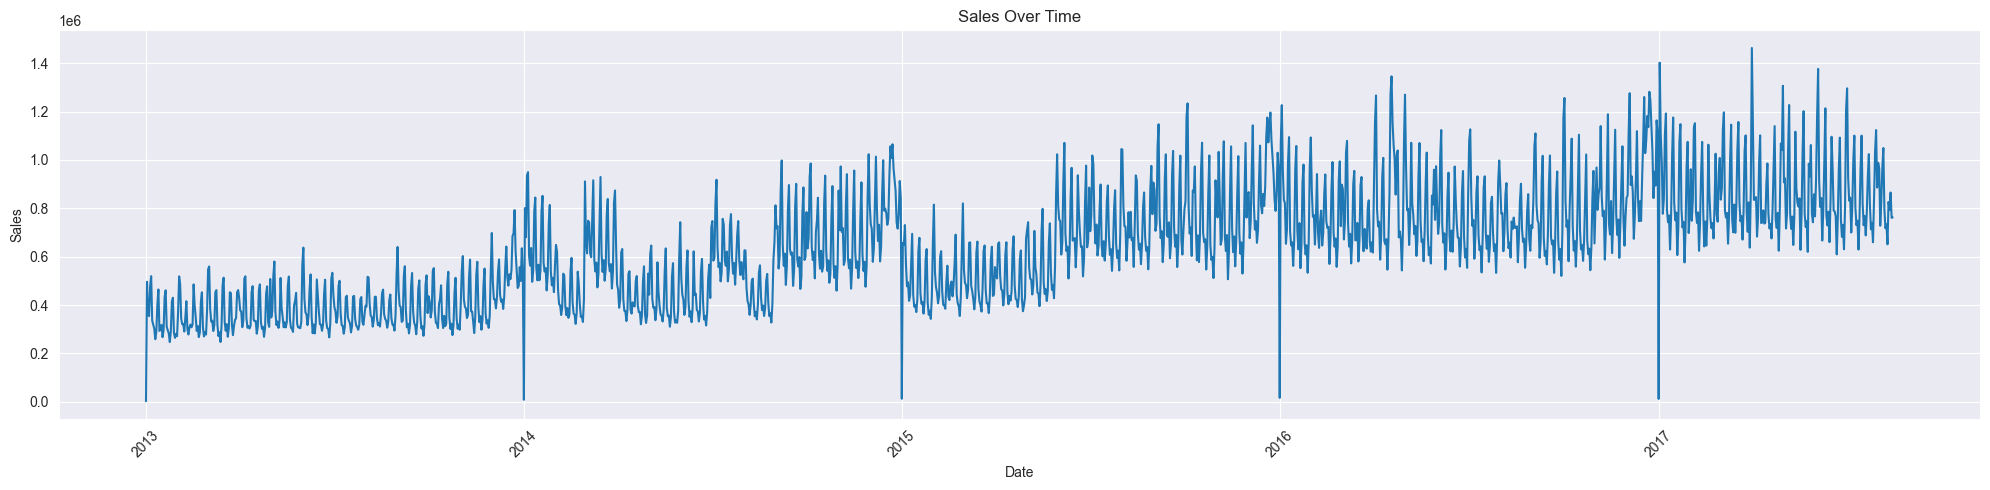

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(all_sales_df["date"], all_sales_df["sales"])

plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

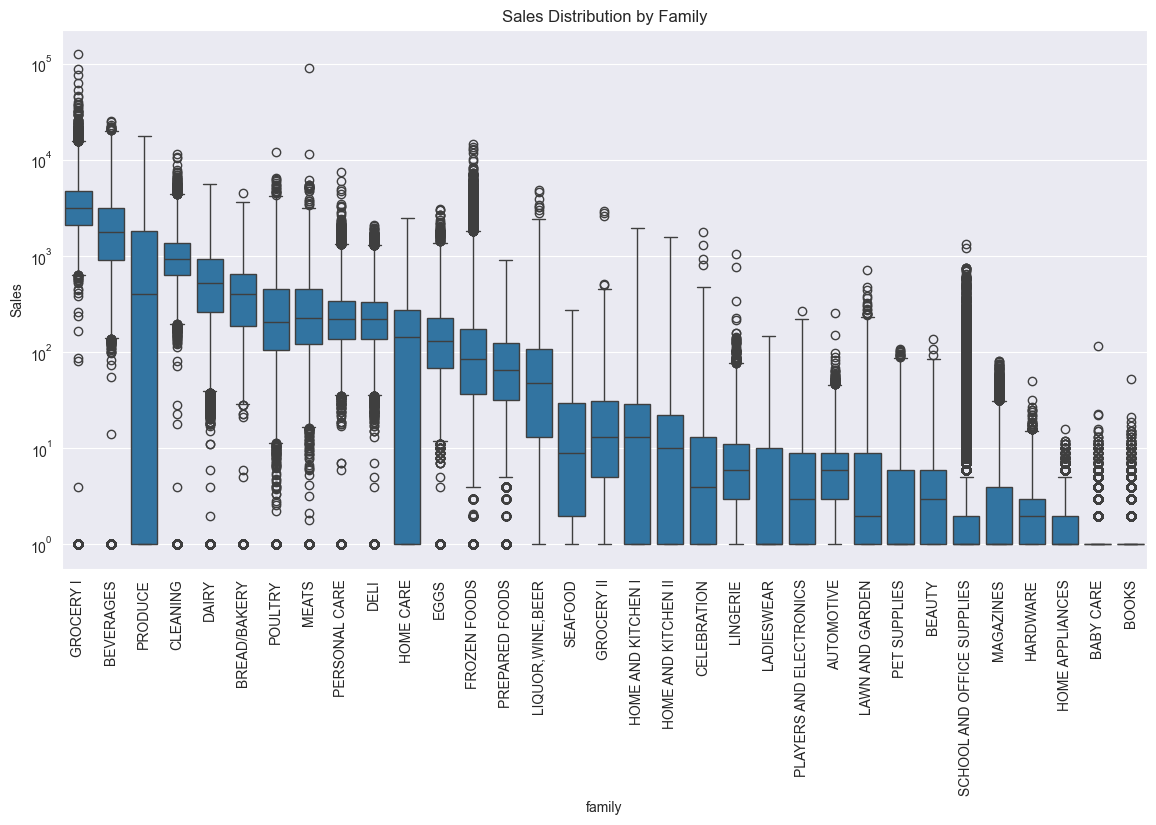

In [17]:
copy_train_df = train_df.copy()
copy_train_df["sales"] += 1

median_sales = train_df.groupby("family")["sales"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=copy_train_df,
    x="family",
    y="sales",
    order=median_sales.index,
    log_scale=True,
)
plt.title("Sales Distribution by Family")
plt.ylabel("Sales")
plt.xticks(rotation=90)
plt.show()

In [18]:
store_family_sales: pd.DataFrame = (
    train_df.groupby(["store_nbr", "family"])["sales"].sum().unstack()
)
store_family_sales_pct = normalize_sales_by_row(store_family_sales)
family_store_sales_pct = normalize_sales_by_col(store_family_sales)

#### Store vs Family Sales
percentage sales of each family in each store (normalized by row)

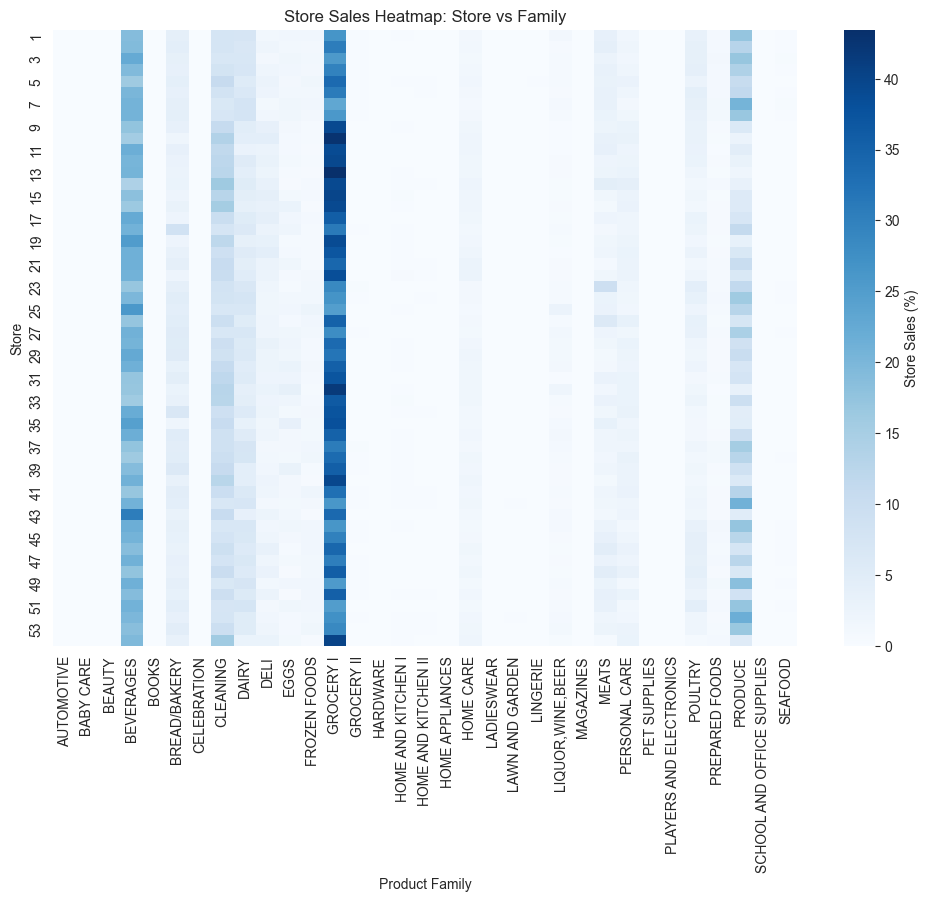

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(store_family_sales_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"})
plt.title("Store Sales Heatmap: Store vs Family")
plt.xlabel("Product Family")
plt.ylabel("Store")
plt.show()

#### Family Sales vs Store
percentage family sales in each store (normalized by column)

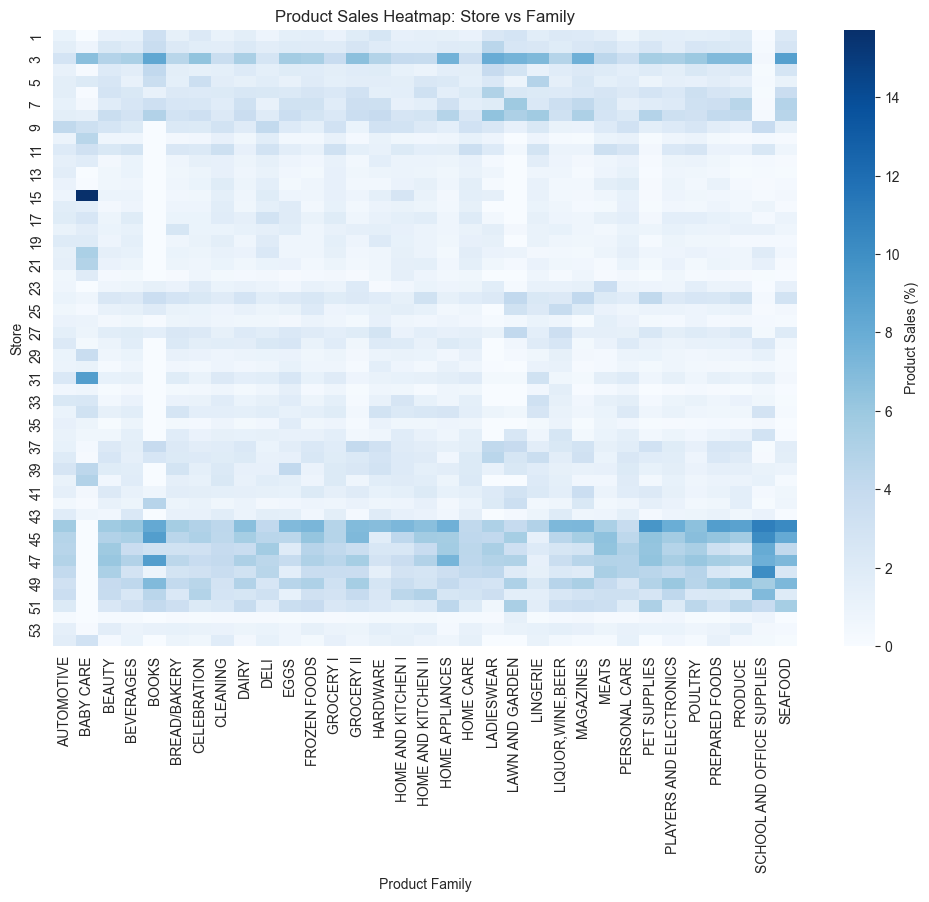

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    family_store_sales_pct, cmap="Blues", cbar_kws={"label": "Product Sales (%)"}
)
plt.title("Product Sales Heatmap: Store vs Family")
plt.xlabel("Product Family")
plt.ylabel("Store")
plt.show()

#### Family Sales Correlation

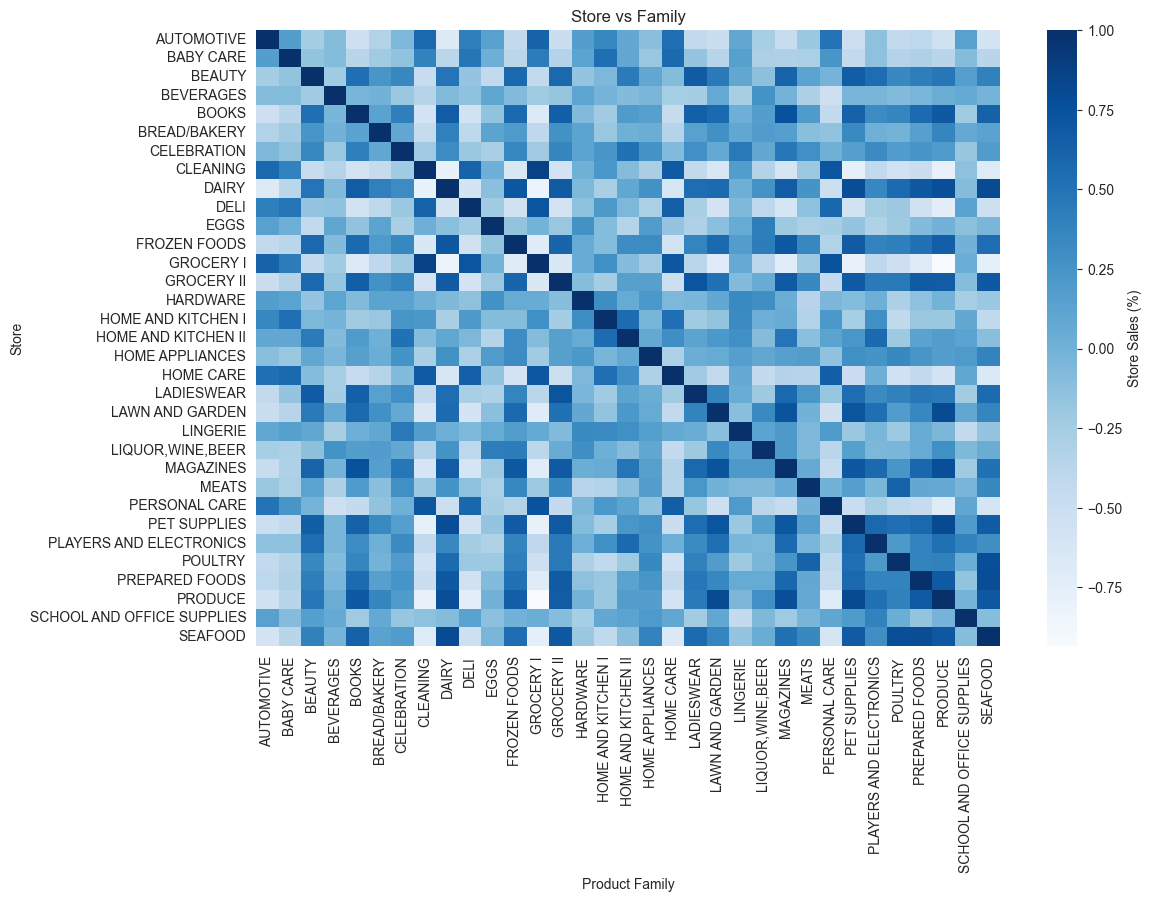

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    store_family_sales_pct.corr(), cbar_kws={"label": "Store Sales (%)"}, cmap="Blues"
)
plt.title("Store vs Family")
plt.xlabel("Product Family")
plt.ylabel("Store")
plt.show()

## test.csv

### Summary
1. The test set expects predictions for the period from **August 16, 2017** to **August 31, 2017**.
2. Predictions are required for each store and each family for every day in the test period.


### Dataset Info

In [22]:
test_df = pd.read_csv(test_path, parse_dates=["date"])

In [23]:
test_df.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [25]:
print("N NaNs:", test_df.isna().sum().sum())

N NaNs: 0


In [26]:
min_test_date = test_df["date"].min()
max_test_date = test_df["date"].max()
test_days_range = (max_test_date - min_test_date).days + 1

print(f"Min Test Date: {min_test_date}")
print(f"Max Test Date: {max_test_date}")
print(f"Test Date Range: {test_days_range} days")

Min Test Date: 2017-08-16 00:00:00
Max Test Date: 2017-08-31 00:00:00
Test Date Range: 16 days


In [27]:
is_no_gaps = n_families * n_stores * test_days_range == test_df.shape[0]
print(f"No gaps in test data: {is_no_gaps}")

No gaps in test data: True


## holidays_events.csv

### Summary
1. The holiday set covers both the train and test periods.
2. It includes **6 unique types** and **3 unique locales**.
3. One holiday falls in the test period: **Fundación de Ambato** on **August 24, 2017**.


### Dataset Info

In [28]:
holidays_events_df = pd.read_csv(holidays_events_path)
holidays_events_df["date"] = pd.to_datetime(holidays_events_df["date"])

In [29]:
holidays_events_df.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [30]:
holidays_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [31]:
holidays_events_df["type"].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [32]:
holidays_events_df["locale"].value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [33]:
min_holiday_date = holidays_events_df["date"].min()
max_holiday_date = holidays_events_df["date"].max()

print(f"Min Holiday Date: {min_holiday_date}")
print(f"Max Holiday Date: {max_holiday_date}")

Min Holiday Date: 2012-03-02 00:00:00
Max Holiday Date: 2017-12-26 00:00:00


In [34]:
print("N NaNs:", holidays_events_df.isna().sum().sum())

N NaNs: 0


In [35]:
n_holidays = holidays_events_df["description"].nunique()

print("N unique holidays:", n_holidays)

N unique holidays: 103


### Exploring Holidays

#### Holidays in Train Period

In [36]:
def get_sales(
    train_data: pd.DataFrame, store_nbr: int | None = None, family: str | None = None
) -> pd.DataFrame:
    if store_nbr is None:
        store_con = pd.Series([True] * len(train_data))
    else:
        store_con = train_data["store_nbr"] == store_nbr
    if family is None:
        family_con = pd.Series([True] * len(train_data))
    else:
        family_con = train_data["family"] == family

    df = train_data[store_con & family_con]
    return df.groupby("date")["sales"].sum().reset_index()

In [37]:
start_holiday_date = min_date - pd.DateOffset(months=1)
end_holiday_date = max_date + pd.DateOffset(months=2)

condition = (holidays_events_df["date"] >= start_holiday_date) & (
    holidays_events_df["date"] <= end_holiday_date
)

In [38]:
limited_holidays_df = holidays_events_df[condition]

In [39]:
sales_to_plot_df = get_sales(train_df, store_nbr=None, family=None)

In [40]:
holiday_to_sales_fig = get_holidays_on_sales_fig(sales_to_plot_df, holidays_events_df)

In [41]:
holiday_to_sales_fig.show()

#### Holidays in Test Period

In [42]:
condition = (holidays_events_df["date"] >= min_test_date) & (
    holidays_events_df["date"] <= max_test_date
)

In [43]:
holidays_events_df[condition]

date     type locale locale_name          description  transferred
327 2017-08-24  Holiday  Local      Ambato  Fundacion de Ambato        False

## oil.csv

### Summary
1. The oil data covers both the train and test periods.
2. The dataset contains **NaN values** and no entries for weekends (Saturday and Sunday).
3. Oil shows a **negative correlation** with sales.


### Oil Info

In [44]:
oil_df = pd.read_csv(oil_path)
oil_df["date"] = pd.to_datetime(oil_df["date"])
oil_df.sort_values("date", inplace=True)

In [45]:
oil_df.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [46]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [47]:
print("N NaNs:", oil_df.isna().sum().sum())

N NaNs: 43


### Exploring Oil Data

#### Test Period

In [48]:
con = oil_df["date"] >= min_test_date
oil_df[con]

date  dcoilwtico
1206 2017-08-16       46.80
1207 2017-08-17       47.07
1208 2017-08-18       48.59
1209 2017-08-21       47.39
1210 2017-08-22       47.65
1211 2017-08-23       48.45
1212 2017-08-24       47.24
1213 2017-08-25       47.65
1214 2017-08-28       46.40
1215 2017-08-29       46.46
1216 2017-08-30       45.96
1217 2017-08-31       47.26

#### Date Gaps

In [49]:
unique_gaps_ranges = oil_df["date"].diff().dt.days.unique()

print("Unique Gaps Ranges:", unique_gaps_ranges)

Unique Gaps Ranges: [nan  1.  3.]


#### Plotting Oil Prices Over Time

In [50]:
oil_df.set_index("date", inplace=True)

In [51]:
oil_df = oil_df.asfreq("D")

In [52]:
oil_df["dcoilwtico"] = oil_df["dcoilwtico"].ffill()

In [53]:
oil_df = oil_df.dropna()

In [54]:
oil_df.head()

dcoilwtico
date                  
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-05       93.12
2013-01-06       93.12

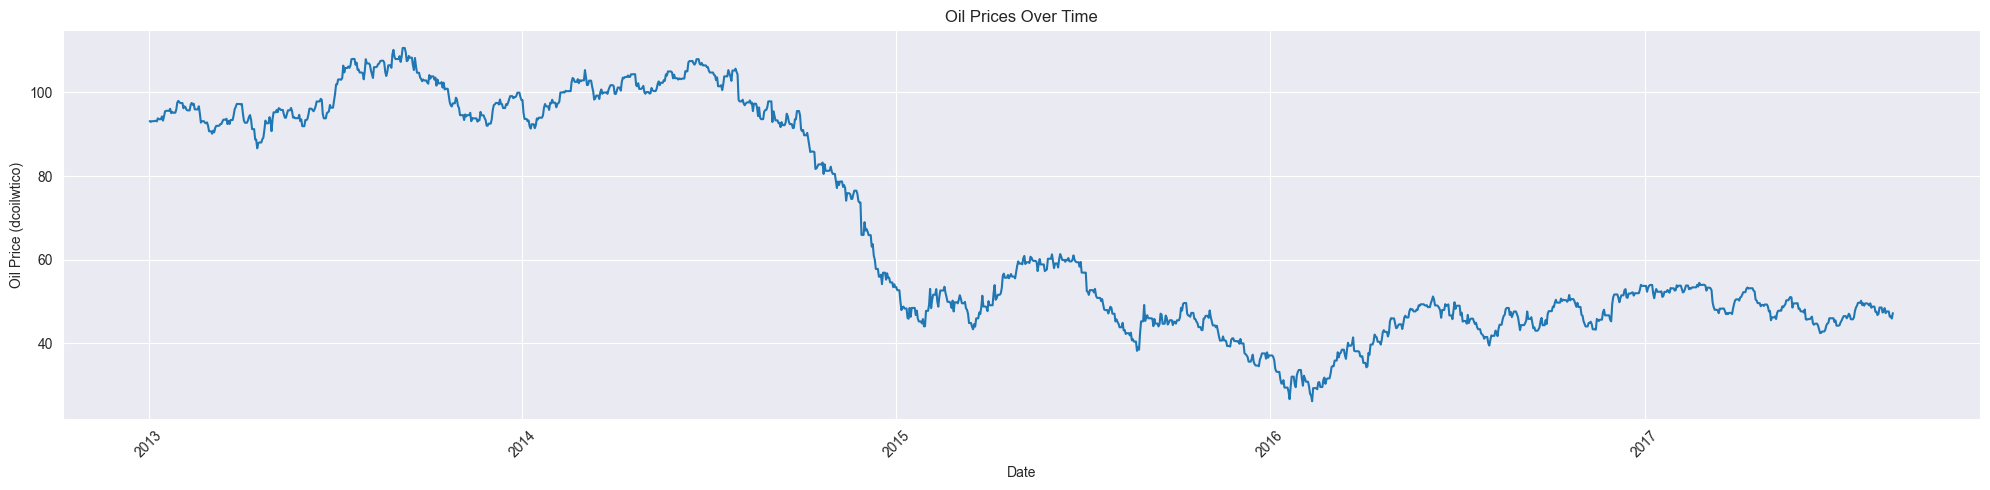

In [55]:
plt.figure(figsize=(20, 5))
plt.plot(oil_df.index, oil_df["dcoilwtico"])

plt.title("Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Price (dcoilwtico)")

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Oil Correlation with Sales

##### Global Correlation

In [56]:
sales_per_day = train_df.groupby("date")["sales"].sum()

In [57]:
oil_to_sales = pd.merge(
    sales_per_day, oil_df, left_index=True, right_on="date", how="inner"
)

In [58]:
corr = oil_to_sales["sales"].corr(oil_to_sales["dcoilwtico"])

In [59]:
print(f"Correlation between oil prices and sales: {corr}")

Correlation between oil prices and sales: -0.6268562268443909


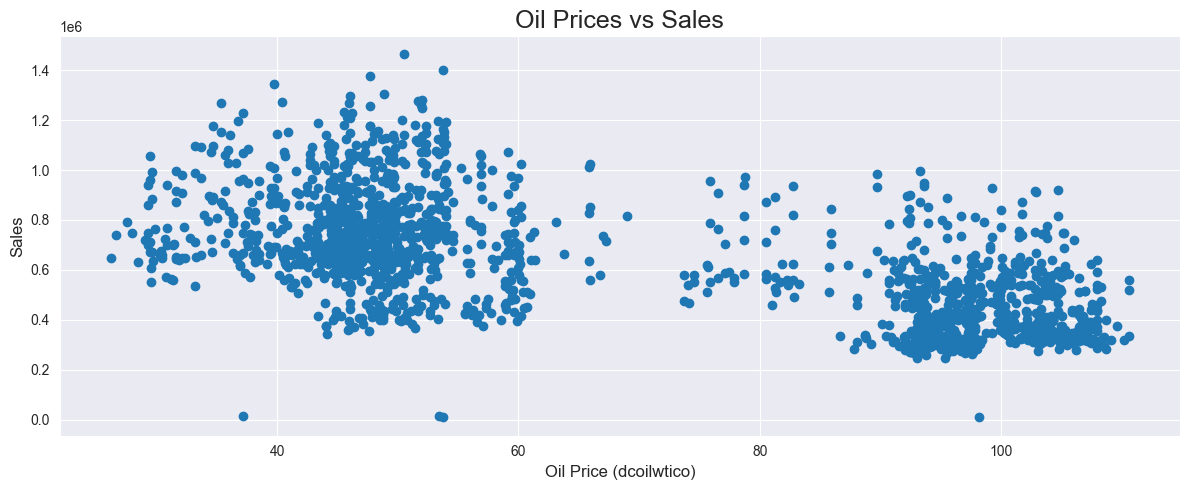

In [60]:
plt.figure(figsize=(12, 5))
plt.scatter(oil_to_sales["dcoilwtico"], oil_to_sales["sales"])

plt.title("Oil Prices vs Sales", fontsize=18)
plt.xlabel("Oil Price (dcoilwtico)", fontsize=12)
plt.ylabel("Sales", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

##### Per Store Correlation

In [61]:
store_sales_per_day = (
    train_df.groupby(["store_nbr", "date"])["sales"].sum().reset_index()
)

In [62]:
store_sales_oil = pd.merge(
    store_sales_per_day, oil_df, left_on="date", right_on="date", how="inner"
)

In [63]:
store_sales_oil_corr = store_sales_oil.groupby("store_nbr")[
    ["sales", "dcoilwtico"]
].corr()
store_sales_oil_corr = store_sales_oil_corr.iloc[0::2, -1].reset_index(
    level=1, drop=True
)

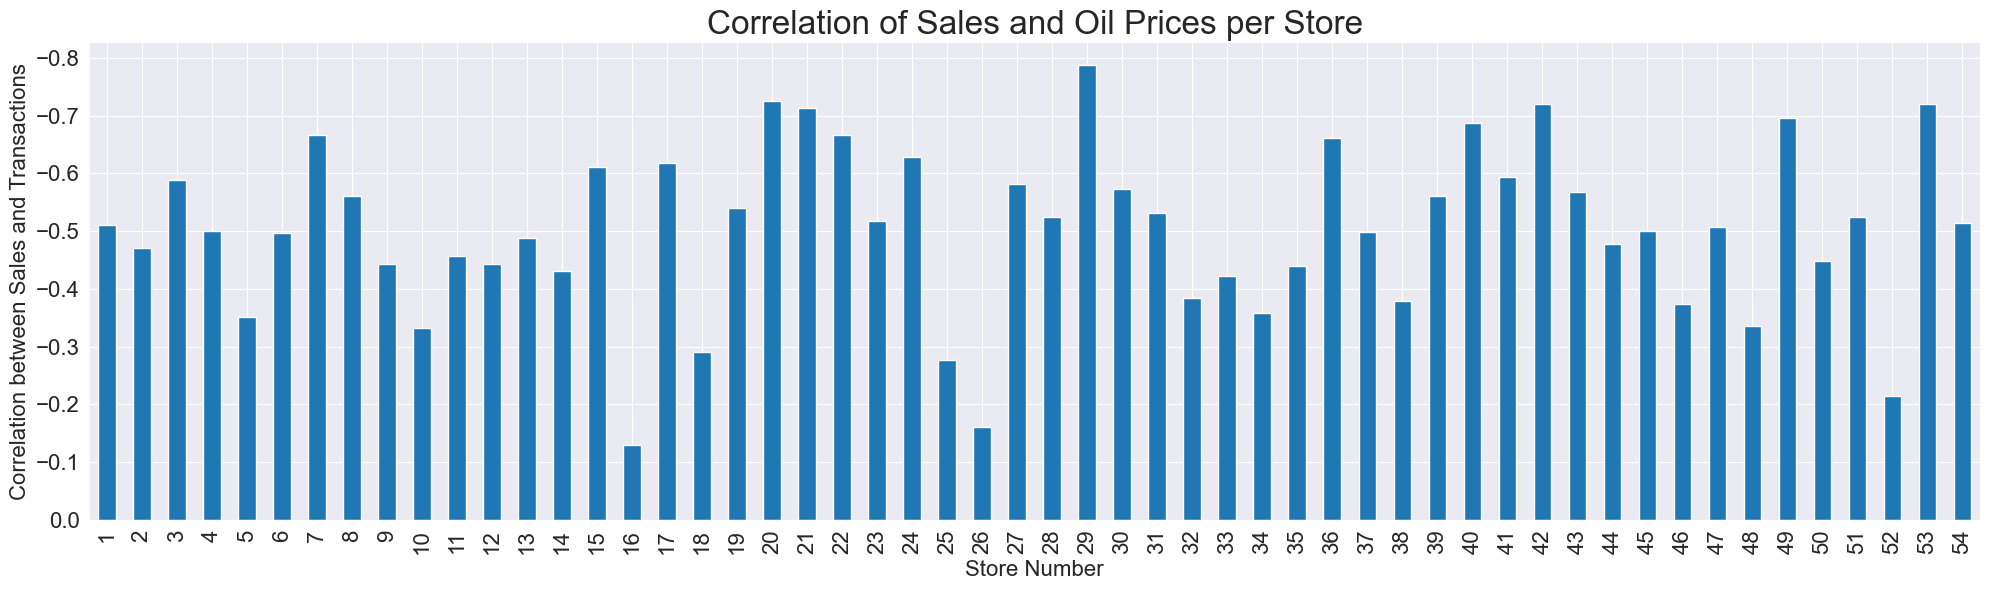

In [64]:
plot_corr_per_store(
    store_sales_oil_corr,
    "Correlation of Sales and Oil Prices per Store",
    reverse_yaxis=True,
)

##### Per Week Correlation

In [65]:
store_sales_oil["bin"] = (
    store_sales_oil["date"].dt.isocalendar().week.astype(str)
    + "-"
    + store_sales_oil["date"].dt.year.astype(str)
)

In [66]:
columns = ["sales", "dcoilwtico"]

weekly_oil_corr = (
    store_sales_oil.groupby(["store_nbr", "bin"])
    .apply(compute_weekly_corr, columns, include_groups=False)
    .reset_index(name="corr")
)

In [67]:
weekly_oil_corr["abs_corr"] = weekly_oil_corr["corr"].abs()
mean_abs_corr_per_store = weekly_oil_corr.groupby("store_nbr")["abs_corr"].mean()

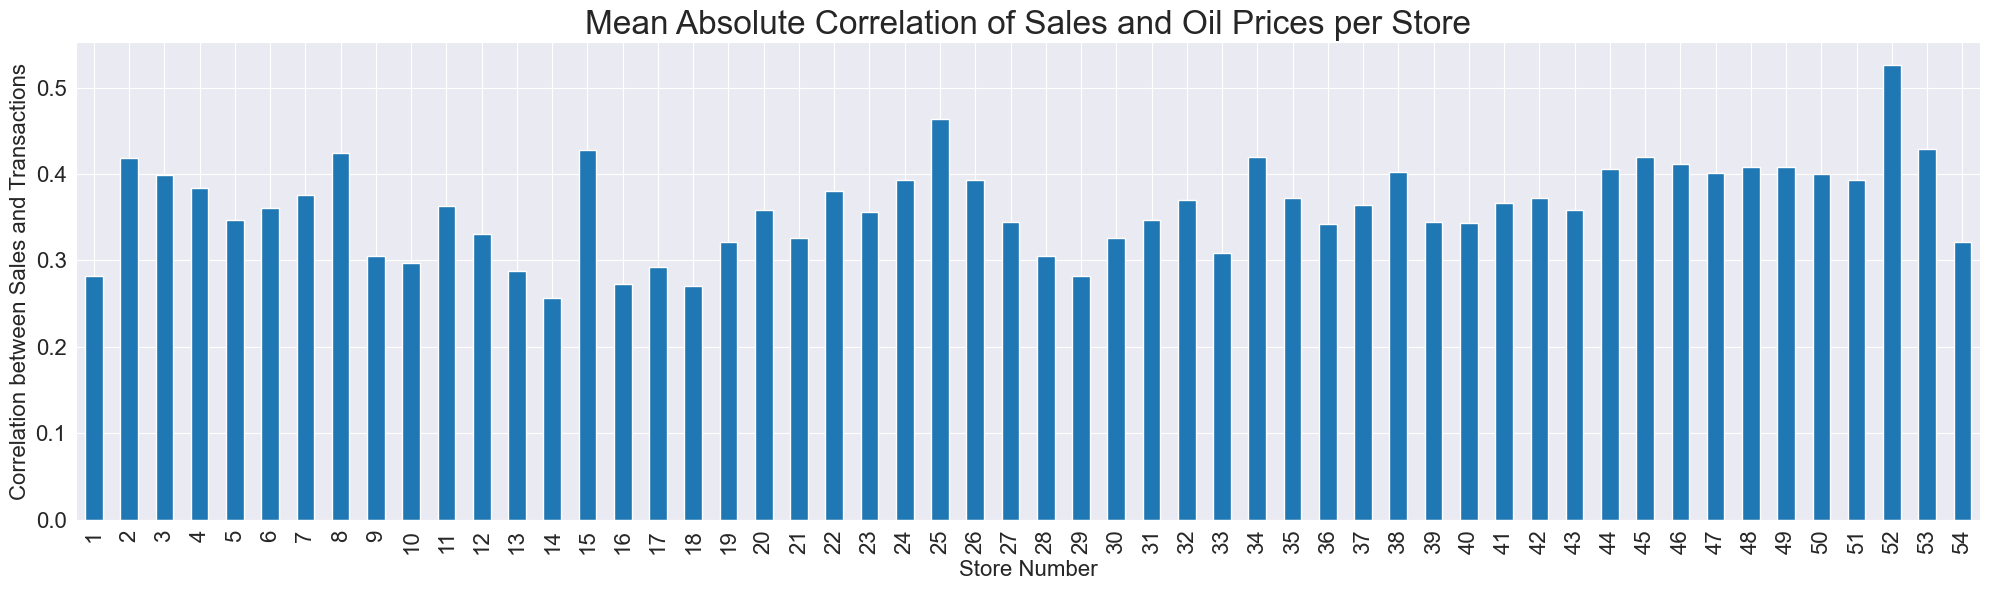

In [68]:
plot_corr_per_store(
    mean_abs_corr_per_store,
    "Mean Absolute Correlation of Sales and Oil Prices per Store",
)

##### Weekly Mean abs Correlation

In [69]:
mean_abs_corr = weekly_oil_corr["abs_corr"].mean()

In [70]:
print(f"Mean Absolute Correlation of Sales and Oil Prices: {mean_abs_corr}")

Mean Absolute Correlation of Sales and Oil Prices: 0.3601318328070953


## stores.csv

### Summary
1. The dataset includes information for all **54 stores**.


### Stores Info

In [71]:
stores_df = pd.read_csv(stores_path)

In [72]:
stores_df["city"].nunique()

22

In [73]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [74]:
print("N NaNs:", stores_df.isna().sum().sum())

N NaNs: 0


In [75]:
stores_df["type"].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

### Exploring Stores Data

#### Sales by Store Type

In [76]:
store_sales = train_df.groupby("store_nbr")["sales"].sum()

In [77]:
store_sales_by_type = pd.merge(
    store_sales, stores_df, left_index=True, right_on="store_nbr", how="inner"
)

In [78]:
sales_per_type = store_sales_by_type.groupby("type")["sales"].sum()

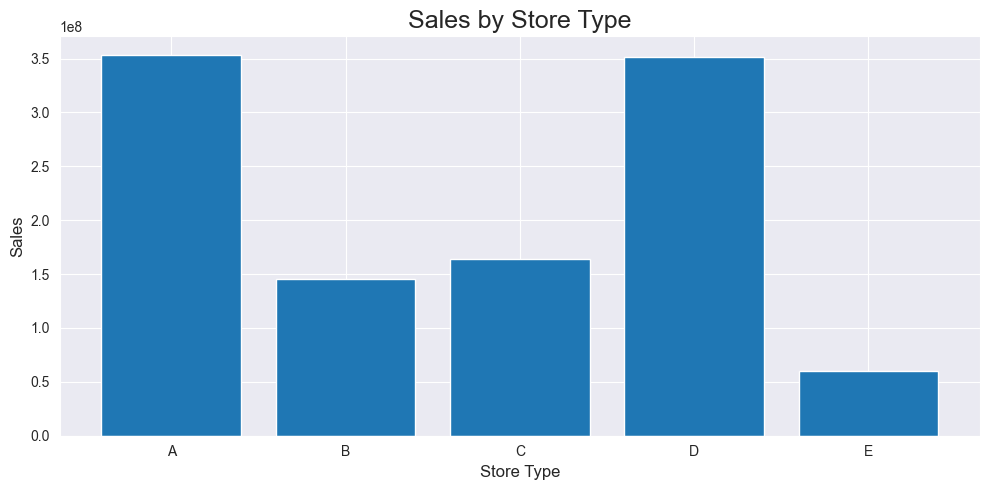

In [79]:
plt.figure(figsize=(10, 5))
plt.bar(sales_per_type.index, sales_per_type.values)

plt.title("Sales by Store Type", fontsize=18)
plt.xlabel("Store Type", fontsize=12)
plt.ylabel("Sales", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

#### Family Sales by Store Type

In [80]:
store_family_sales_by_type = pd.merge(
    store_family_sales,
    stores_df[["type", "store_nbr"]],
    left_index=True,
    right_on="store_nbr",
    how="inner",
)
store_family_sales_by_type.drop("store_nbr", axis=1, inplace=True)

store_family_sales_by_type = store_family_sales_by_type.groupby("type").sum()

In [81]:
store_family_sales_by_type_pct = normalize_sales_by_row(store_family_sales_by_type)
family_store_sales_by_type_pct = normalize_sales_by_col(store_family_sales_by_type)

##### Normalized by Row

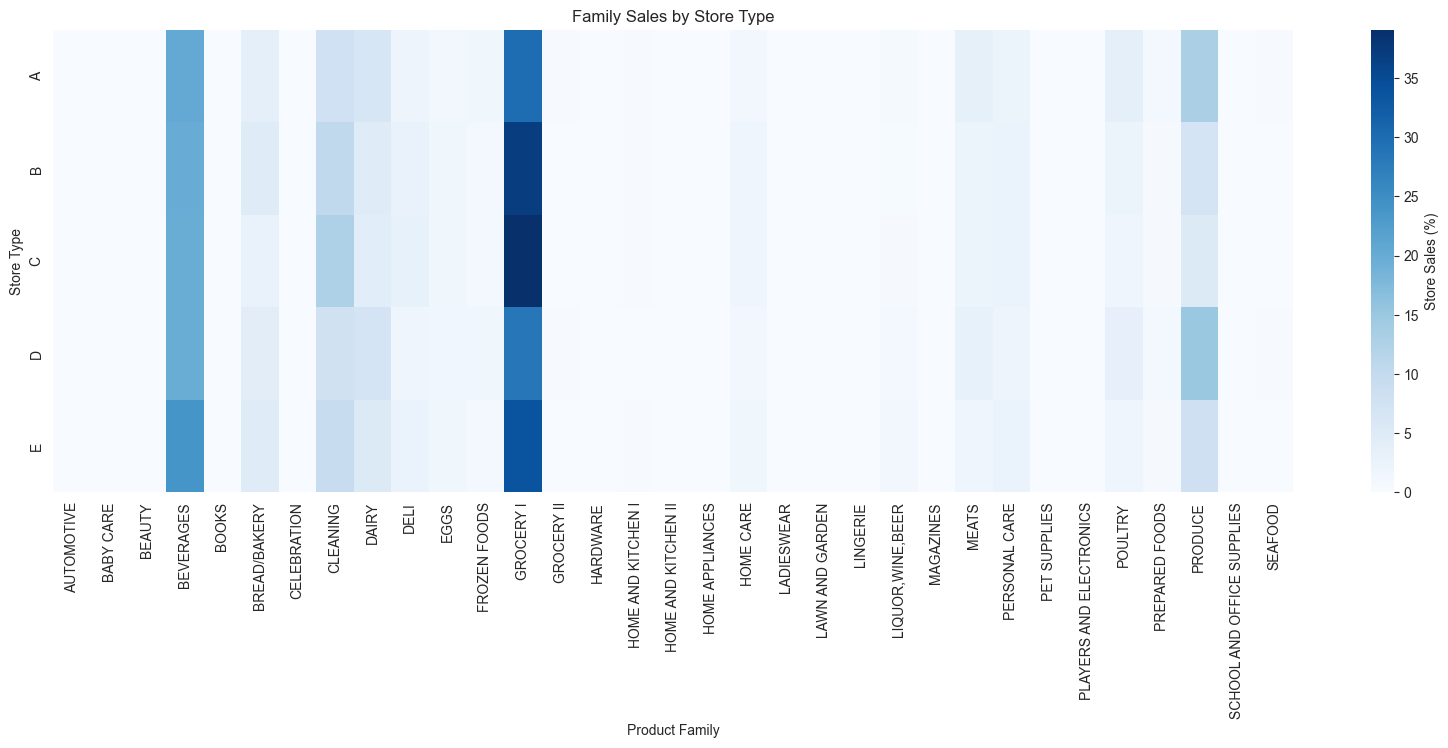

In [82]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    store_family_sales_by_type_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"}
)
plt.title("Family Sales by Store Type")
plt.xlabel("Product Family")
plt.ylabel("Store Type")
plt.show()

##### Normalized by Column

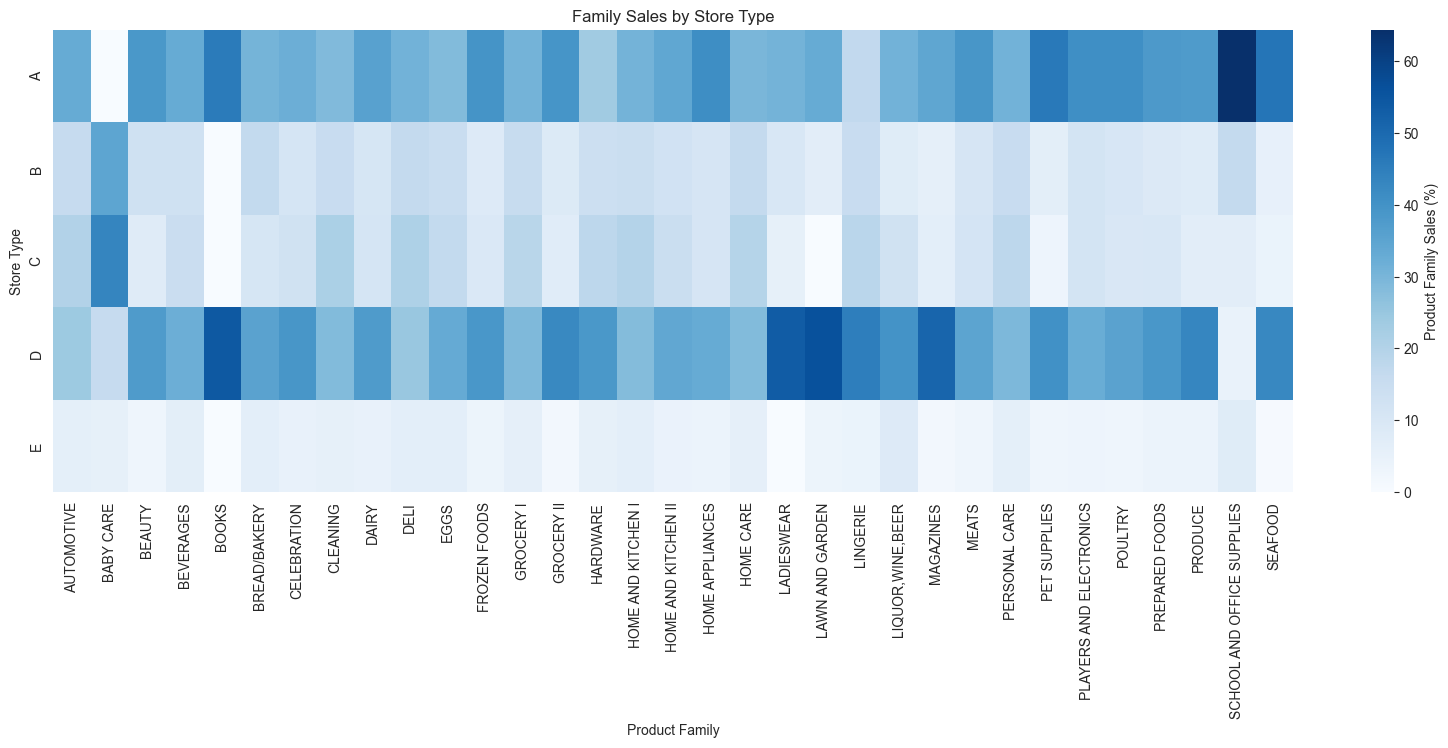

In [83]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    family_store_sales_by_type_pct,
    cmap="Blues",
    cbar_kws={"label": "Product Family Sales (%)"},
)
plt.title("Family Sales by Store Type")
plt.xlabel("Product Family")
plt.ylabel("Store Type")
plt.show()

#### Sales to Day of Week

In [84]:
store_to_train_df = pd.merge(
    train_df, stores_df, left_on="store_nbr", right_on="store_nbr", how="inner"
)

In [85]:
family_sales_by_dayofweek = (
    train_df.groupby(["day_of_week", "family"])["sales"].sum().unstack()
)
store_sales_by_dayofweek = (
    train_df.groupby(["day_of_week", "store_nbr"])["sales"].sum().unstack()
)
store_type_sales_by_dayofweek = (
    store_to_train_df.groupby(["day_of_week", "type"])["sales"].sum().unstack()
)
store_cluster_sales_by_dayofweek = (
    store_to_train_df.groupby(["day_of_week", "cluster"])["sales"].sum().unstack()
)

In [86]:
family_sales_by_dayofweek_pct = normalize_sales_by_row(family_sales_by_dayofweek)
store_sales_by_dayofweek_pct = normalize_sales_by_row(store_sales_by_dayofweek)
store_type_sales_by_dayofweek_pct = normalize_sales_by_row(
    store_type_sales_by_dayofweek
)
store_cluster_sales_by_dayofweek_pct = normalize_sales_by_row(
    store_cluster_sales_by_dayofweek
)

##### Normalized by Row

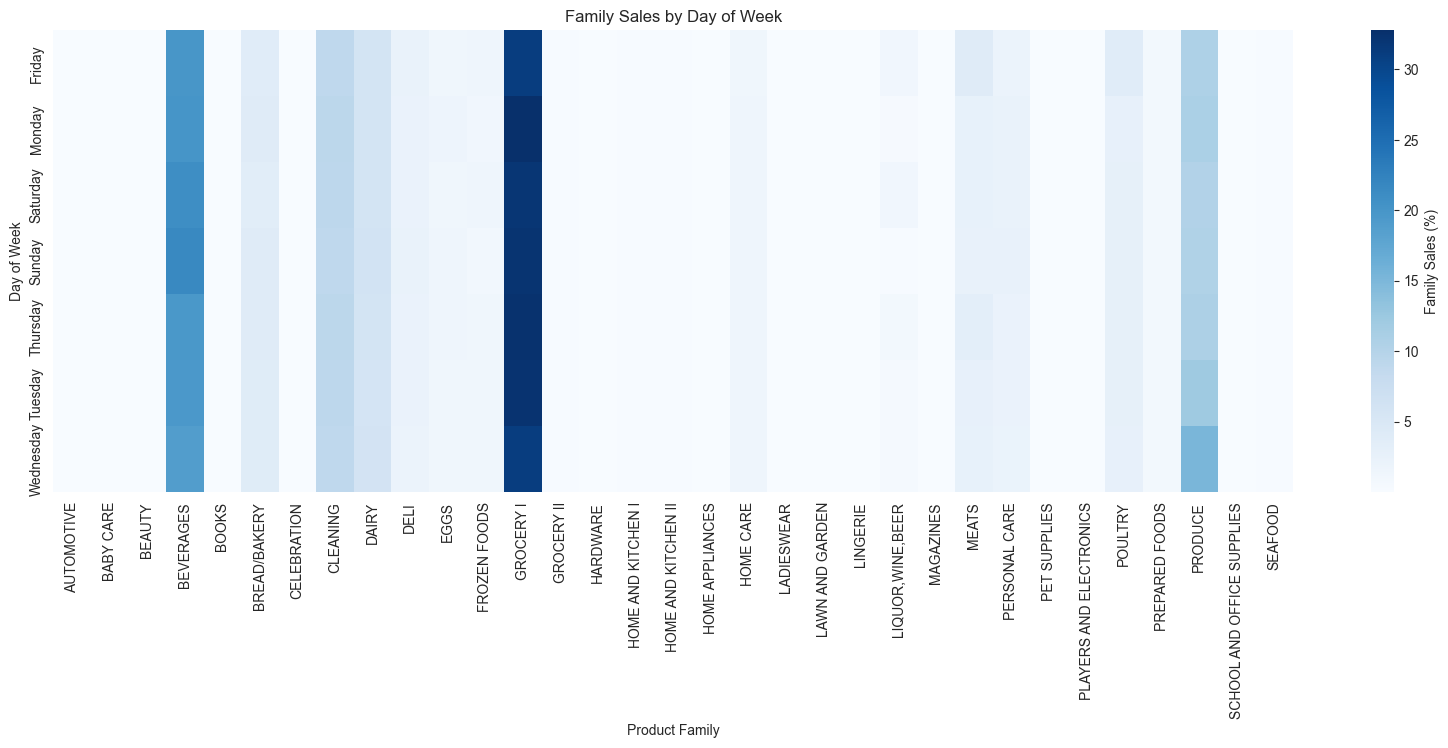

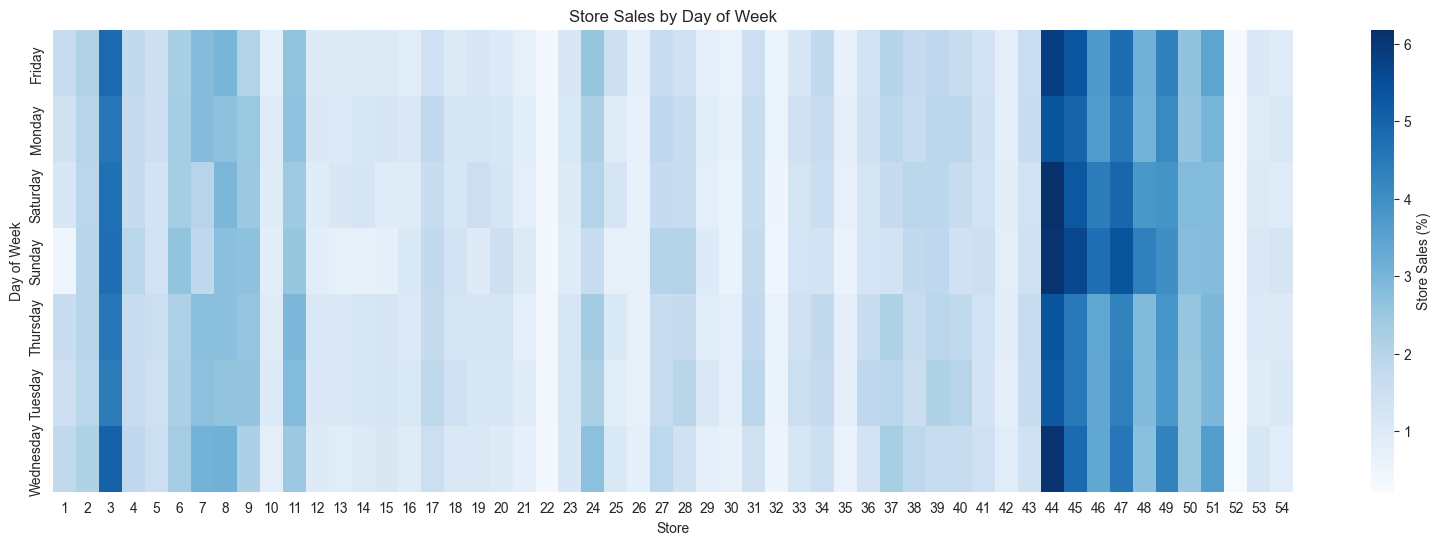

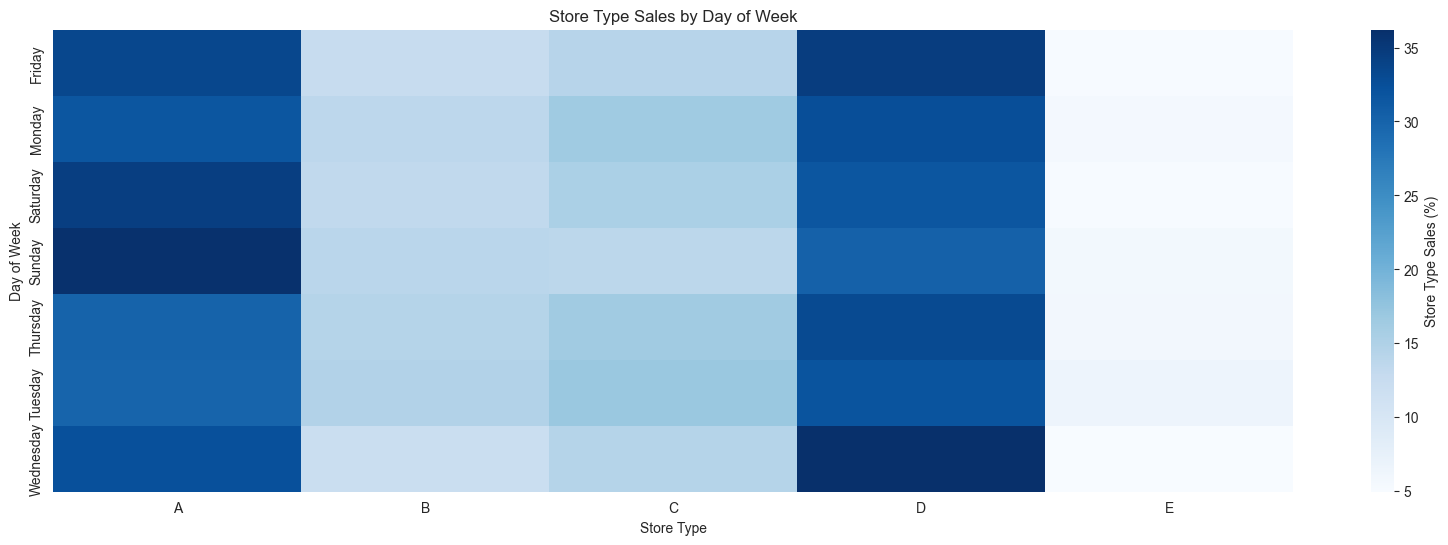

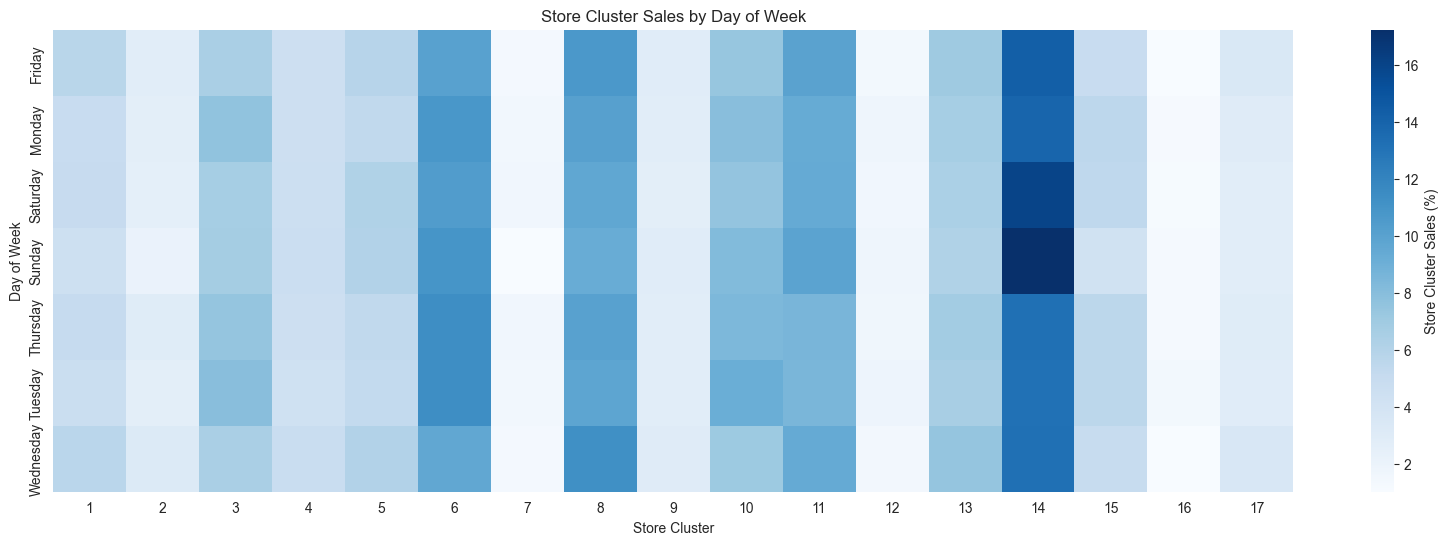

In [87]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    family_sales_by_dayofweek_pct, cmap="Blues", cbar_kws={"label": "Family Sales (%)"}
)
plt.title("Family Sales by Day of Week")
plt.xlabel("Product Family")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    store_sales_by_dayofweek_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"}
)
plt.title("Store Sales by Day of Week")
plt.xlabel("Store")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    store_type_sales_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Type Sales (%)"},
)
plt.title("Store Type Sales by Day of Week")
plt.xlabel("Store Type")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    store_cluster_sales_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Cluster Sales (%)"},
)
plt.title("Store Cluster Sales by Day of Week")
plt.xlabel("Store Cluster")
plt.ylabel("Day of Week")
plt.show()


##### Normalized by Column

In [128]:
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

In [129]:
sales_to_family_by_dayofweek_pct = normalize_sales_by_col(
    family_sales_by_dayofweek
).reindex(day_order)

sales_to_store_by_dayofweek_pct = normalize_sales_by_col(
    store_sales_by_dayofweek
).reindex(day_order)

sales_to_store_type_by_dayofweek_pct = normalize_sales_by_col(
    store_type_sales_by_dayofweek
).reindex(day_order)

sales_to_store_cluster_by_dayofweek_pct = normalize_sales_by_col(
    store_cluster_sales_by_dayofweek
).reindex(day_order)

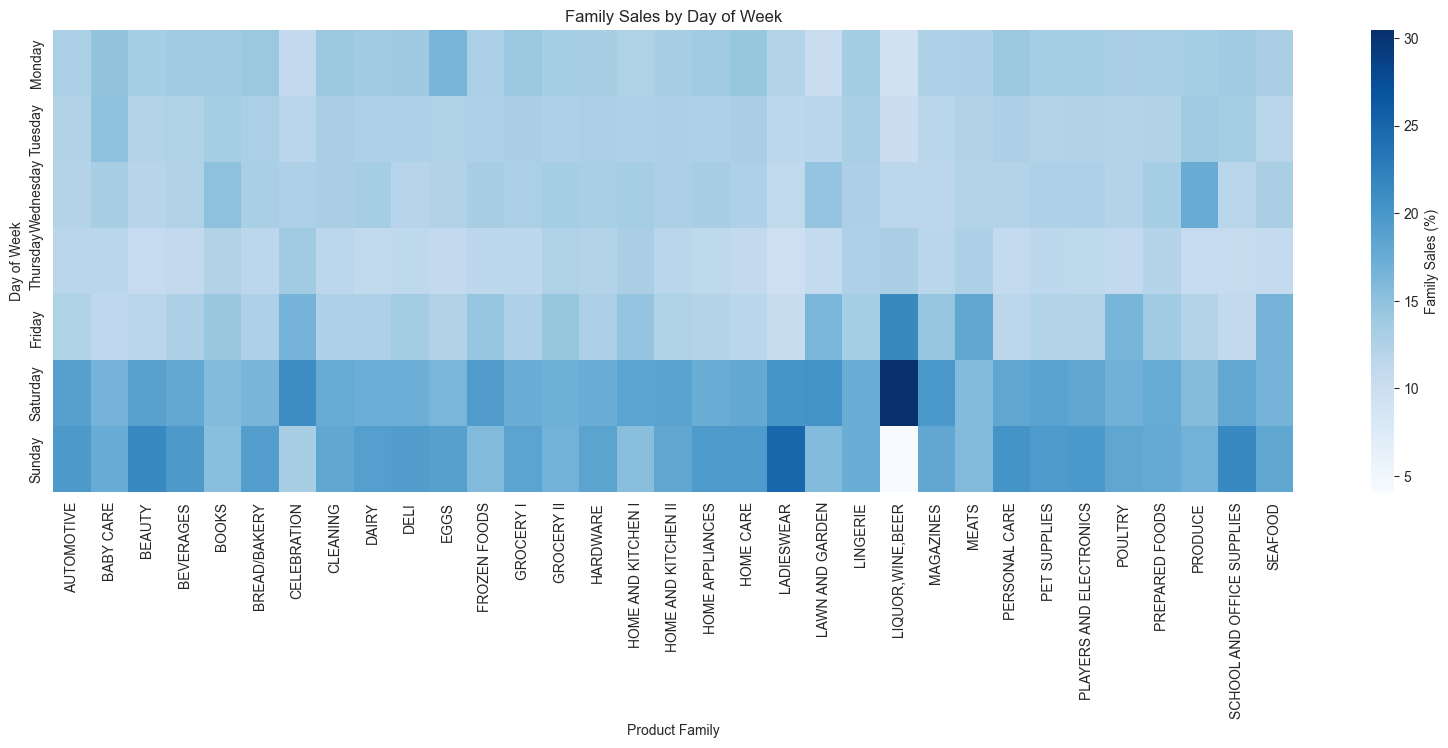

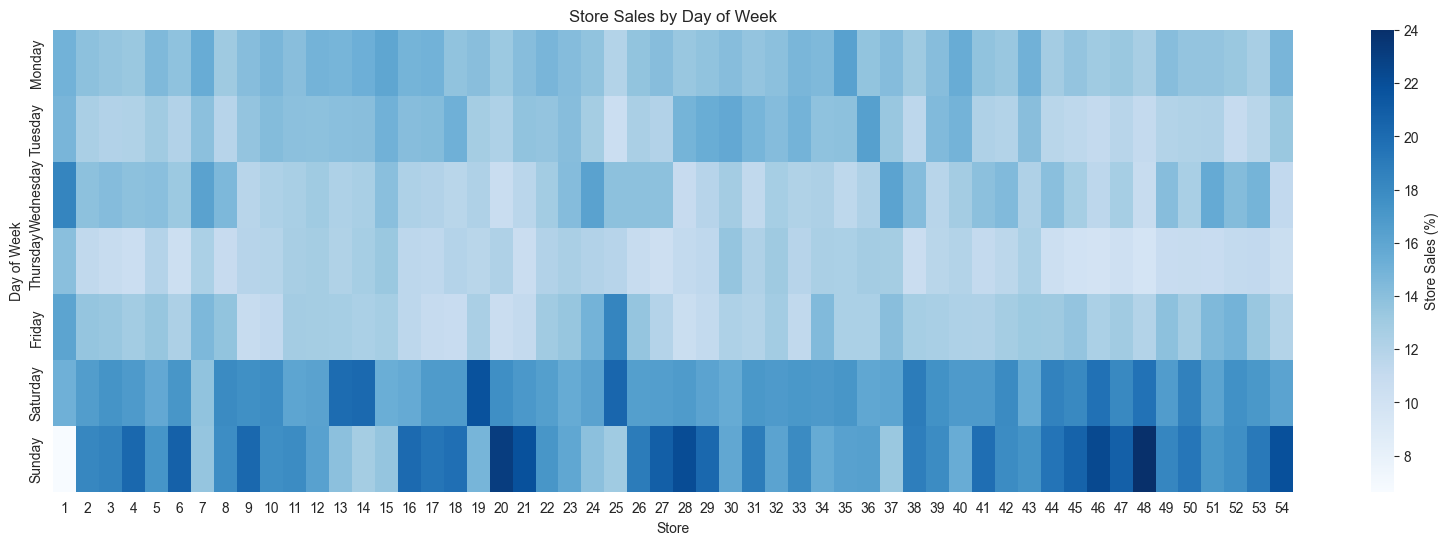

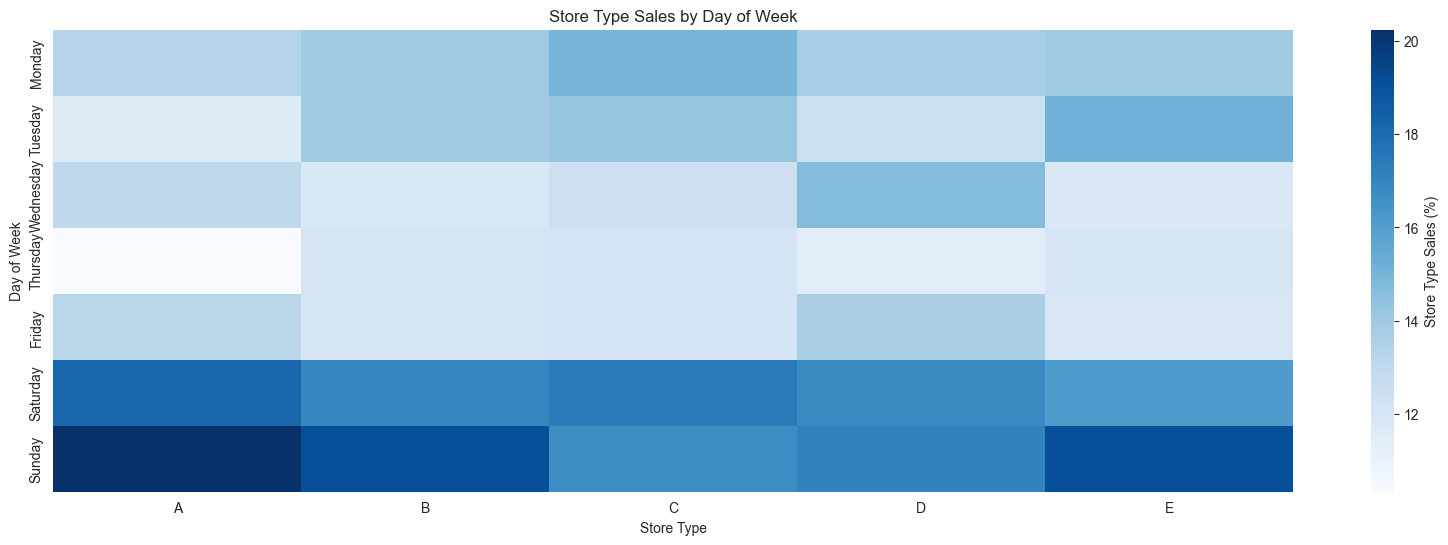

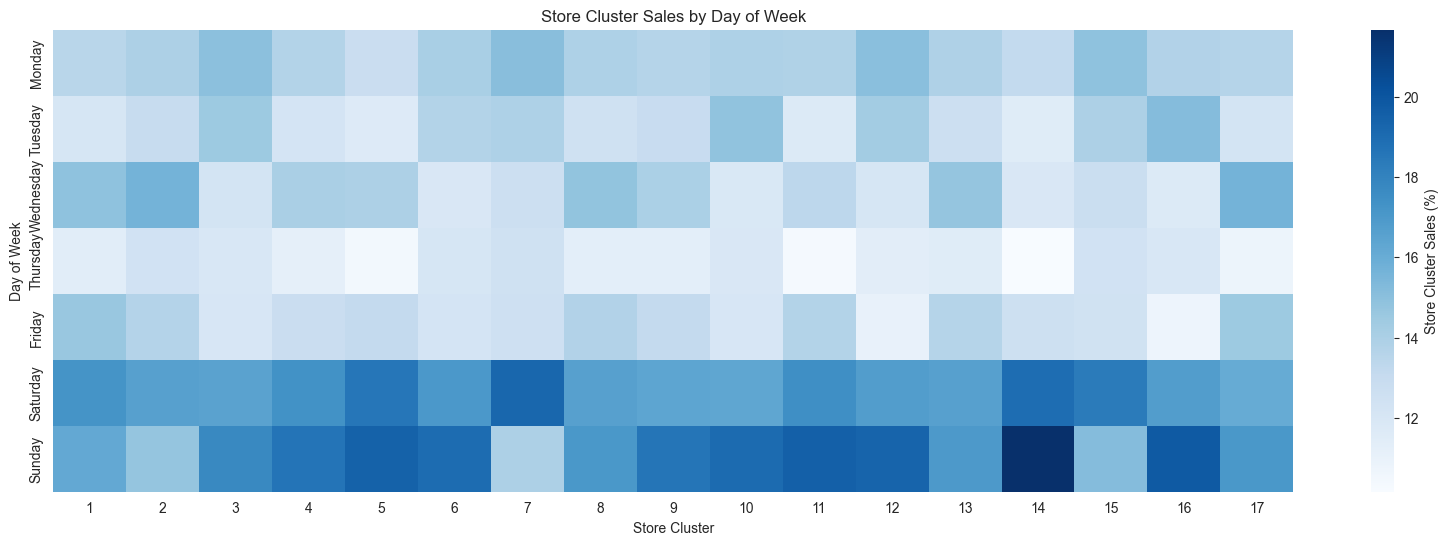

In [130]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_family_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Family Sales (%)"},
)
plt.title("Family Sales by Day of Week")
plt.xlabel("Product Family")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_store_by_dayofweek_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"}
)
plt.title("Store Sales by Day of Week")
plt.xlabel("Store")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_store_type_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Type Sales (%)"},
)
plt.title("Store Type Sales by Day of Week")
plt.xlabel("Store Type")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_store_cluster_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Cluster Sales (%)"},
)
plt.title("Store Cluster Sales by Day of Week")
plt.xlabel("Store Cluster")
plt.ylabel("Day of Week")
plt.show()

## transactions.csv

### Summary

1. The transactions data covers only the **train period**.
2. The dataset includes information for all **54 stores**.
3. Certain stores have missing transaction data for some periods.
4. Transactions show a **positive correlation** with sales.


### Transactions Info

In [90]:
transactions_df = pd.read_csv(transactions_path)
transactions_df["date"] = pd.to_datetime(transactions_df["date"])

In [91]:
transactions_df.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [92]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [93]:
print("N NaNs:", transactions_df.isna().sum().sum())

N NaNs: 0


In [94]:
is_max_train_date = np.all(
    transactions_df.groupby("store_nbr")["date"].max() == max_date
)
print(f"Max date in transactions is the same as in train: {is_max_train_date}")

Max date in transactions is the same as in train: True


In [95]:
is_info_about_all_store = transactions_df["store_nbr"].nunique() == n_stores
print(f"transactions.csv contains info about all stores: {is_info_about_all_store}")

transactions.csv contains info about all stores: True


### Exploring Transactions Data

#### Date Gaps

In [96]:
store_25_data = transactions_df[transactions_df["store_nbr"] == 25]
store_25_data = store_25_data[store_25_data["date"] >= "2016-01-01"]

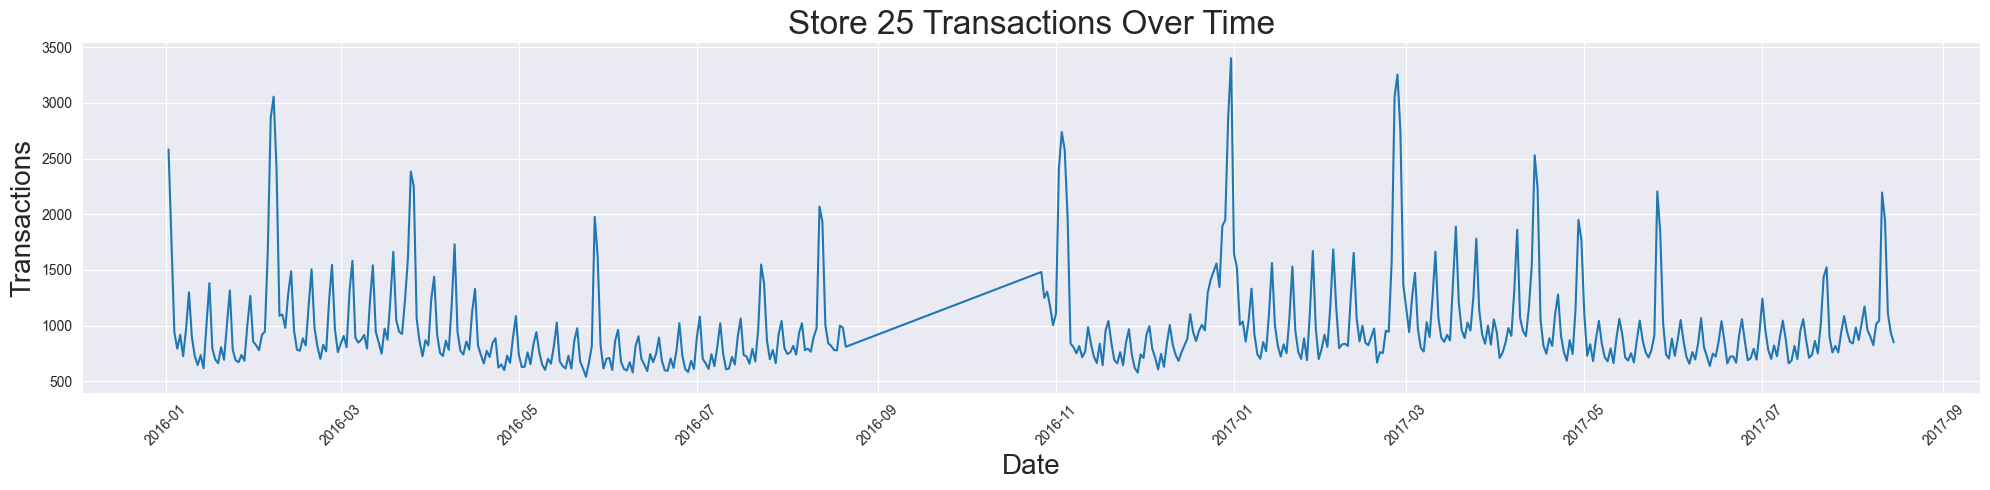

In [97]:
plt.figure(figsize=(20, 5))
plt.plot(store_25_data["date"], store_25_data["transactions"])

plt.title("Store 25 Transactions Over Time", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Transactions", fontsize=20)

plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Transactions Over Time for All Stores

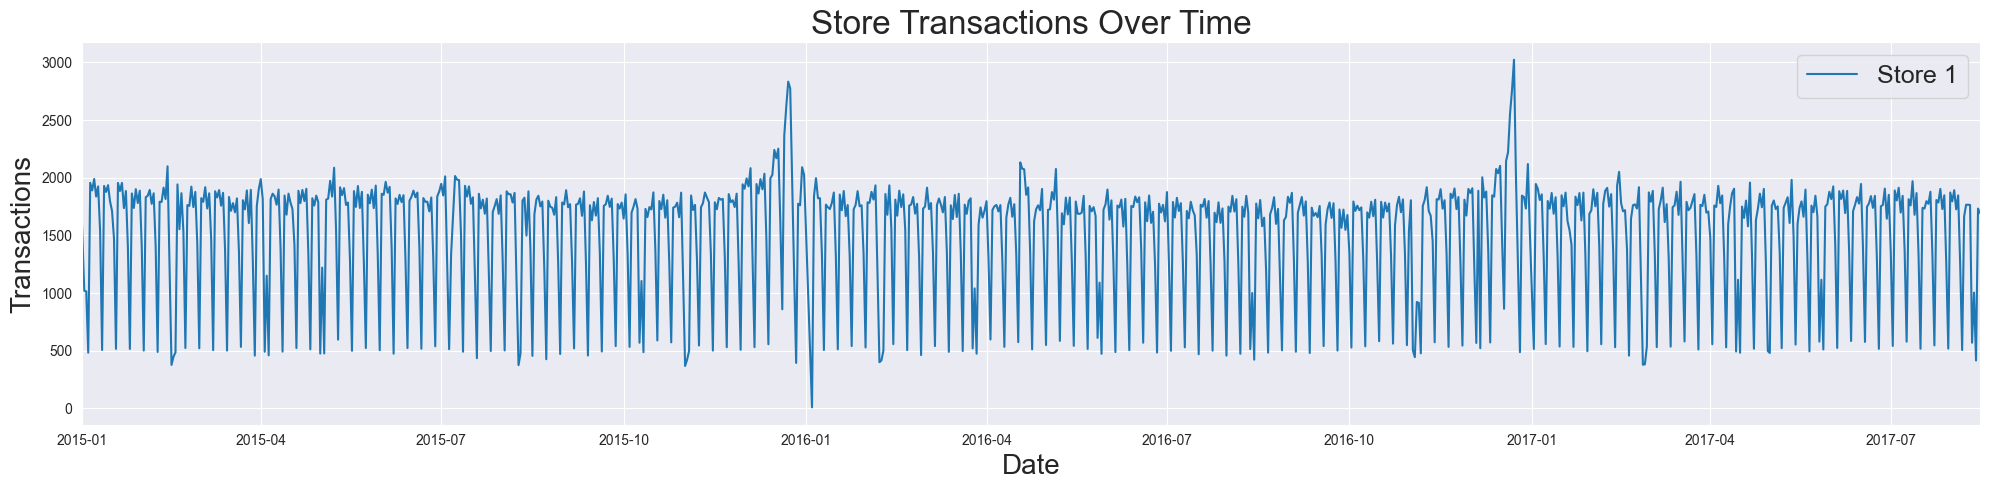

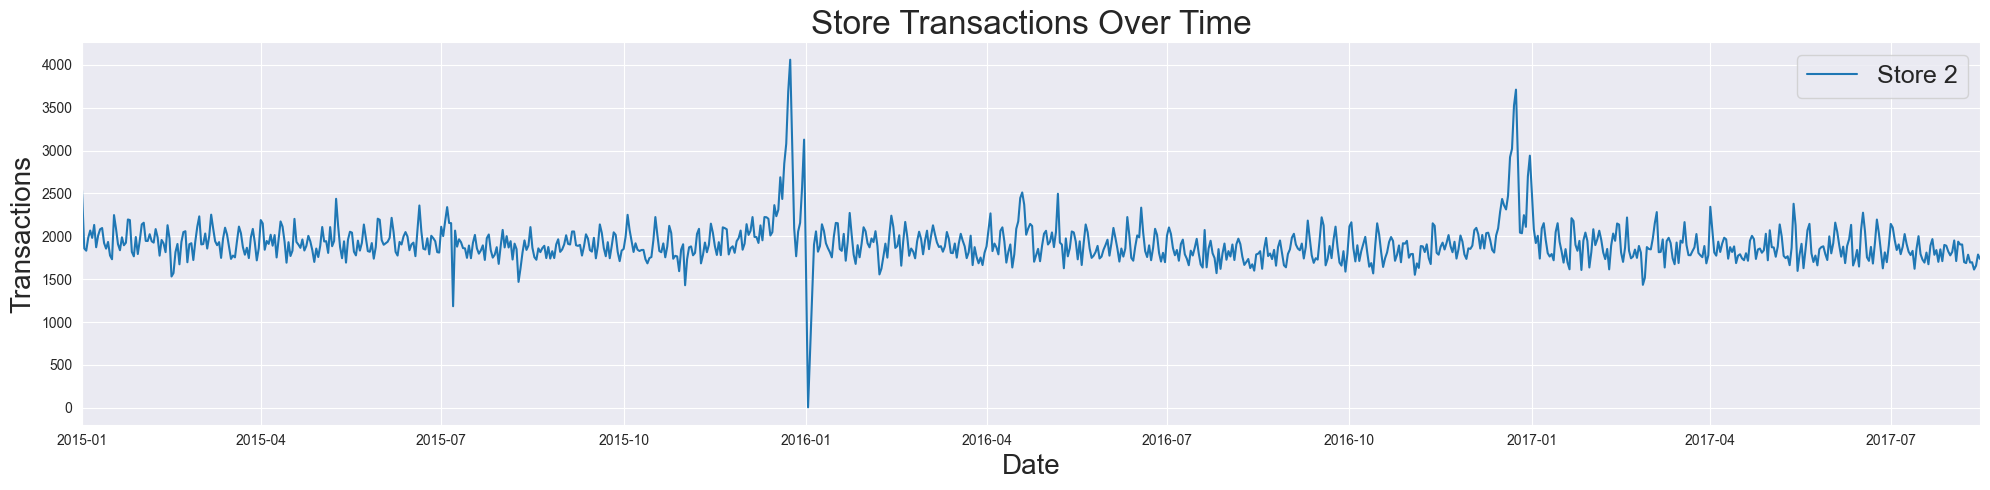

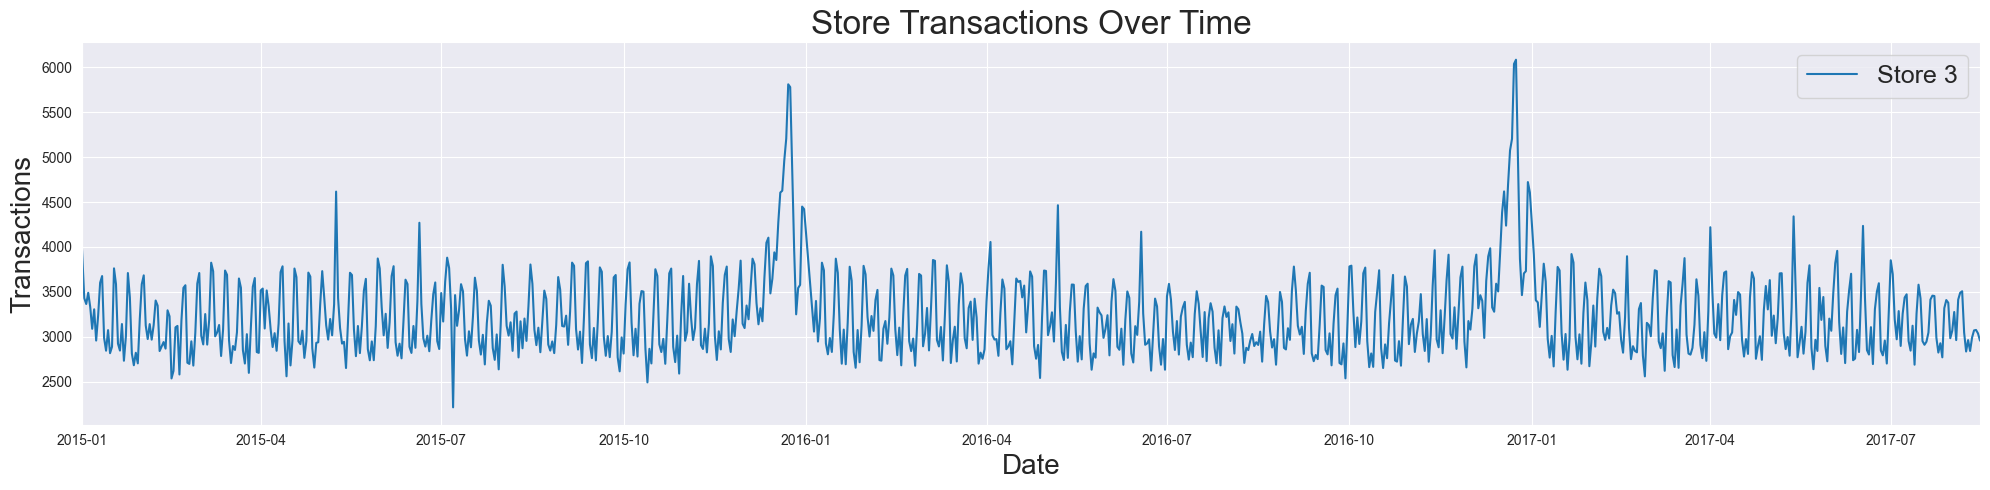

In [98]:
start_date = "2015-01-01"
end_date = transactions_df["date"].max()
stores_to_plot_ = [1, 2, 3]

for i_store in stores_to_plot_:
    plt.figure(figsize=(20, 5))
    df_store = transactions_df[transactions_df["store_nbr"] == i_store]

    plt.plot(df_store["date"], df_store["transactions"], label=f"Store {i_store}")

    plt.title("Store Transactions Over Time", fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Transactions", fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)

    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    plt.tight_layout()
    plt.show()

#### Store Transactions Correlation with Sales

In [99]:
store_sales_per_day = train_df.groupby(["store_nbr", "date"])["sales"].sum()

In [100]:
store_sales_transactions = pd.merge(
    store_sales_per_day, transactions_df, on=["store_nbr", "date"], how="inner"
)

##### Global Correlation

In [101]:
store_sales_transactions[["sales", "transactions"]].corr()

sales  transactions
sales         1.000000      0.837384
transactions  0.837384      1.000000

##### Per Store Correlation

In [102]:
store_sales_transactions_corr = (
    store_sales_transactions.groupby("store_nbr")[["sales", "transactions"]]
    .corr()
    .iloc[0::2, -1]
).reset_index(level=1, drop=True)

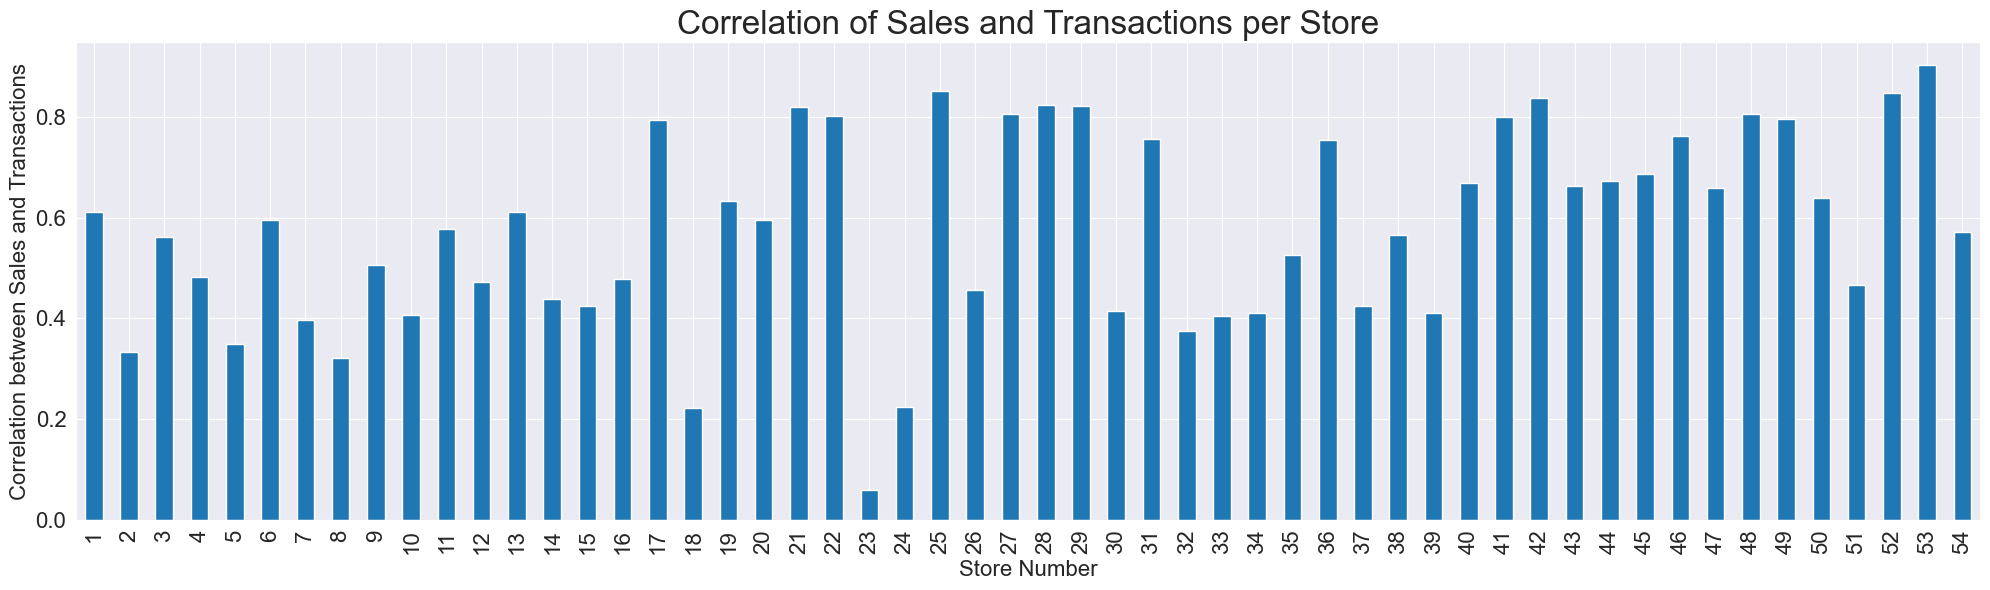

In [103]:
plot_corr_per_store(
    store_sales_transactions_corr, "Correlation of Sales and Transactions per Store"
)

##### Local Correlation

In [104]:
store_sales_transactions["week"] = (
    store_sales_transactions["date"].dt.isocalendar().week
)

In [105]:
columns = ["sales", "transactions"]

weekly_corr = (
    store_sales_transactions.groupby(["store_nbr", "week"])
    .apply(compute_weekly_corr, columns, include_groups=False)
    .reset_index(name="corr")
)

In [106]:
weekly_corr["abs_corr"] = weekly_corr["corr"].abs()

In [107]:
mean_abs_corr_per_store = weekly_corr.groupby("store_nbr")["abs_corr"].mean()

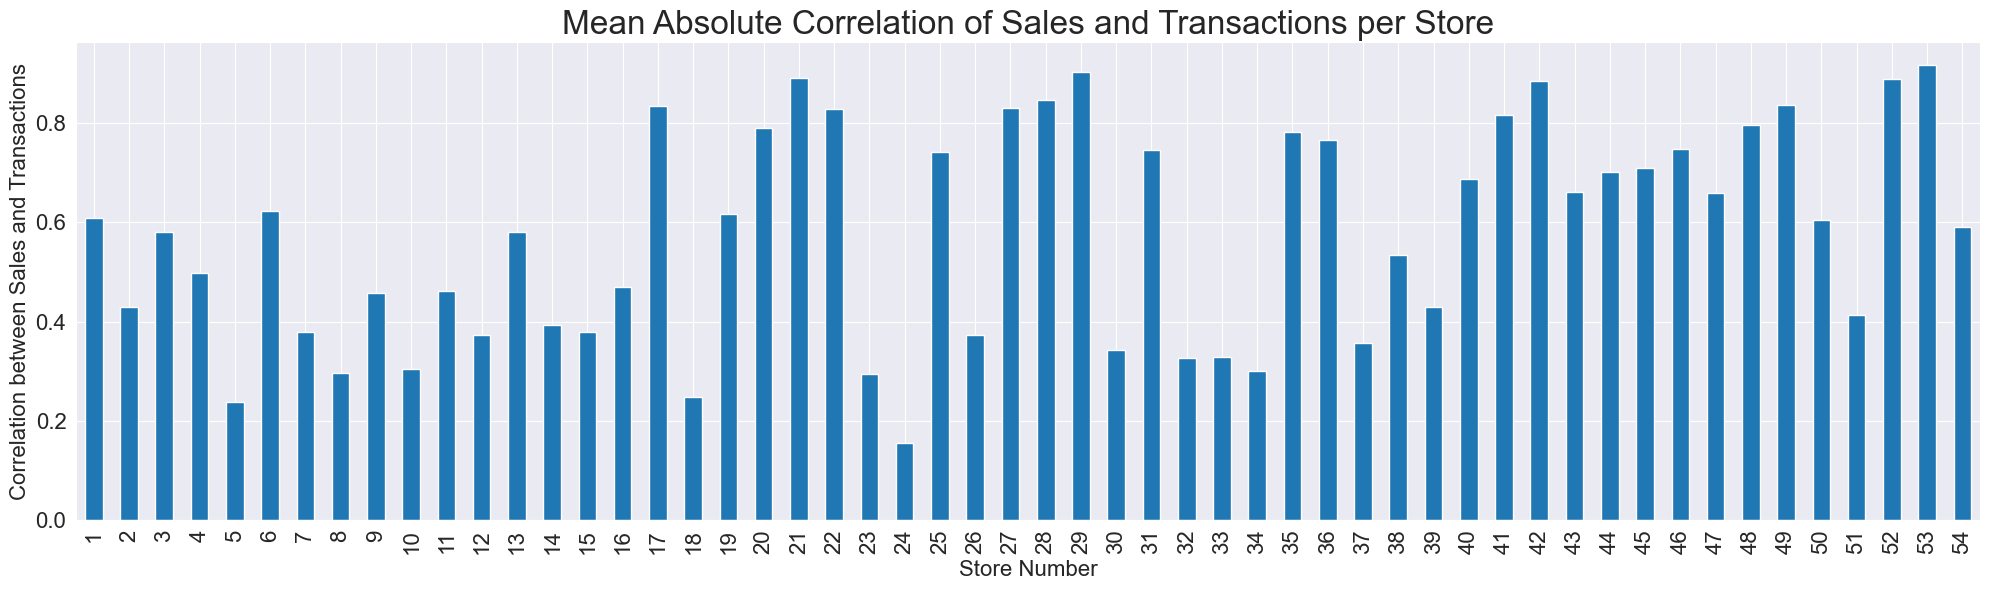

In [108]:
plot_corr_per_store(
    mean_abs_corr_per_store,
    "Mean Absolute Correlation of Sales and Transactions per Store",
)

## sample_submission.csv

In [109]:
sample_submission_df = pd.read_csv(sample_submission_path, index_col="id")

In [110]:
sample_submission_df.head()

sales
id            
3000888    0.0
3000889    0.0
3000890    0.0
3000891    0.0
3000892    0.0

### mean sales per store

In [111]:
test_df.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [112]:
mean_sales_per_store = train_df.groupby(["store_nbr", "family"])["sales"].mean()

In [113]:
prediction = test_df.merge(
    mean_sales_per_store, on=["store_nbr", "family"], how="inner"
)

In [114]:
prediction.set_index("id", inplace=True)

In [115]:
prediction.head()

date  store_nbr      family  onpromotion        sales
id                                                                 
3000888 2017-08-16          1  AUTOMOTIVE            0     3.251188
3000889 2017-08-16          1   BABY CARE            0     0.000000
3000890 2017-08-16          1      BEAUTY            2     2.408551
3000891 2017-08-16          1   BEVERAGES           20  1587.748812
3000892 2017-08-16          1       BOOKS            0     0.125297

In [116]:
sample_submission_df["sales"] = prediction["sales"]

In [117]:
sample_submission_df.head()

sales
id                  
3000888     3.251188
3000889     0.000000
3000890     2.408551
3000891  1587.748812
3000892     0.125297

In [118]:
file_path = os.path.join(SUBMISSIONS_PATH, "mean_sales_per_store.csv")

In [119]:
sample_submission_df.to_csv(file_path)